# UCI regression 

In [479]:
import jax
import optax
import pickle
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

import datagen
from functools import partial
from bayes_opt import BayesianOptimization
from jax.sharding import PositionalSharding
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import gauss_filter as gfilter
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [480]:
devices = jax.devices()
sharding = PositionalSharding(devices)

In [481]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [482]:
%config InlineBackend.figure_format = "retina"

In [486]:
uci = datagen.UCIDatasets("./data")
for dataset_name in sorted(uci.datasets, key=lambda x: -len(x)):
    dataset = uci.load_dataset(dataset_name)
    print(dataset_name, dataset.shape)

protein-tertiary-structure (45731, 10)
naval-propulsion-plant (11935, 18)
wine-quality-red (1600, 12)
bostonHousing (507, 14)
power-plant (9569, 5)
concrete (1031, 9)
energy (769, 9)
kin8nm (8193, 9)
yacht (309, 7)


In [487]:
dataset_name = "wine-quality-red"
noise_type = "target" # or "covariate"

X_collection= []
y_collection = []
ix_clean_collection = []

n_runs = 50
v_error = 50
seed_init = 314
for i in range(n_runs):
    if noise_type == "target":
        data = uci.sample_one_sided_noisy_dataset(dataset_name, p_error=0.05, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].astype(bool)
    elif noise_tyoe == "covariate":
        data = uci.sample_noisy_covariates(dataset_name, p_error=0.05, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].any(axis=1).astype(bool)
    else:
        raise KeyError(f"Noise {noise_type} not available")
        
    X = data["X"]
    y = data["y"]
    
    
    X_collection.append(X)
    y_collection.append(y)
    ix_clean_collection.append(ix_clean)

In [488]:
X_collection = jnp.array(X_collection)
y_collection = jnp.array(y_collection)
mask_clean = np.array(ix_clean_collection).T
X_collection.shape

(50, 1440, 11)

In [489]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Setup

In [490]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [491]:
y, X = y_collection[0], X_collection[0]
ix_clean = ix_clean_collection[0]

In [492]:
Q = 0.0
observation_covariance = 1.0

In [493]:
key = jax.random.PRNGKey(314)
model = MLP()
params_init = model.init(key, X[:1])

In [494]:
X_collection.shape

(50, 1440, 11)

## EKF

In [495]:
def filter_ekf(log_lr):
    lr = np.exp(log_lr)
    agent = gfilter.ExtendedKalmanFilter(
        lambda x: x,
        model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance  * jnp.eye(1),
    )

    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel_imq, yhat_pp = agent.scan(bel_init, y, X, callback_fn=callback)
    out = (agent, bel_imq)
    return yhat_pp.squeeze(), out

def opt_step(log_lr):
    res = -jnp.power(filter_ekf(log_lr)[0] - y, 2)
    res = np.median(res)
    
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [496]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 2         | -0.7086   | -2.057    |
| 3         | -0.2783   | -3.675    |
CPU times: user 1min 17s, sys: 37.4 s, total: 1min 54s
Wall time: 25.8 s


In [497]:
%%time

lr = np.exp(bo.max["params"]["log_lr"])
agent = gfilter.ExtendedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=Q,
    observation_covariance=1.0 * jnp.eye(1),
)

bel_init = agent.init_bel(params_init, cov=lr)

callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))
res = scanfn(bel_init, y_collection, X_collection, callback)

res = jax.block_until_ready(res)
state_final_collection, yhat_collection_ekf = res
yhat_collection_ekf = yhat_collection_ekf.squeeze()

CPU times: user 26.5 s, sys: 1.19 s, total: 27.7 s
Wall time: 1min 10s


In [498]:
err_collection_ekf = pd.DataFrame(np.power(y_collection - yhat_collection_ekf, 2).T)

## WLF-IMQ

### Hparam choice

In [499]:
def filter_imqf(soft_threshold, log_lr):
    lr = np.exp(log_lr)
    agent = gbfilter.IMQFilter(
        model.apply, dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold
    )

    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.link_fn)
    bel_imq, yhat_pp = agent.scan(bel_init, y, X, callback_fn=callback)
    out = (agent, bel_imq)
    return yhat_pp.squeeze(), out

def opt_step(soft_threshold, log_lr):
    # res = -jnp.power(filter_imqf(soft_threshold, log_lr)[0] - y, 2)[ix_clean].mean()
    res = -jnp.power(filter_imqf(soft_threshold, log_lr)[0] - y, 2)
    res = jnp.median(res)
    
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [500]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "soft_threshold": (1e-6, 15),
        "log_lr": (-5, 0),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   | soft_t... |
-------------------------------------------------
| 4         | -0.008506 | -1.36     | 3.907     |
| 5         | -0.008076 | -0.4412   | 3.911     |
CPU times: user 1min 18s, sys: 37 s, total: 1min 55s
Wall time: 26.6 s


### Eval

In [501]:
soft_threshold = bo.max["params"]["soft_threshold"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = gbfilter.IMQFilter(
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0,
    soft_threshold=soft_threshold
)

In [502]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.link_fn)
_, yhat_collection_wlf = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_wlf = jax.block_until_ready(yhat_collection_wlf.squeeze())

CPU times: user 25.9 s, sys: 955 ms, total: 26.9 s
Wall time: 1min 9s


In [503]:
err_collection_wlf = pd.DataFrame(np.power(y_collection - yhat_collection_wlf, 2).T)

## IW-based EKF
(Agamenoni 2012)

### Hparam choice

In [504]:
def filter_rkf(noise_scaling, log_lr):
    lr = np.exp(log_lr)
    agent_rekf = rfilter.ExtendedRobustKalmanFilter(
        lambda x: x, model.apply, dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance * jnp.eye(1),
        noise_scaling=noise_scaling,
        n_inner=1
    )
    
    bel_init = agent_rekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, yhat_pp = agent_rekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_rekf, bel_rekf)
    
    return yhat_pp.squeeze(), out

In [505]:
def opt_step(noise_scaling, log_lr):
    # res = -jnp.power(filter_rkf(noise_scaling, log_lr)[0] - y, 2)[ix_clean].mean()
    res = -jnp.power(filter_rkf(noise_scaling, log_lr)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [506]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "noise_scaling": (1e-6, 15),
        "log_lr": (-5, 0)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   | noise_... |
-------------------------------------------------
| 5         | -0.007673 | -0.4412   | 3.911     |
CPU times: user 37.2 s, sys: 33.2 s, total: 1min 10s
Wall time: 6.44 s


### Eval

In [507]:
noise_scaling = bo.max["params"]["noise_scaling"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = rfilter.ExtendedRobustKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    prior_observation_covariance=1.0 * jnp.eye(1),
    n_inner=1,
    noise_scaling=noise_scaling,
)

In [508]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.vobs_fn)
_, yhat_collection_ann1 = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ann1 = yhat_collection_ann1.squeeze()

CPU times: user 4.16 s, sys: 98.1 ms, total: 4.25 s
Wall time: 2.89 s


In [509]:
err_collection_ann1 = pd.DataFrame(np.power(y_collection - yhat_collection_ann1, 2).T)

## WLF-MD
Weighted likelihood filter with Mahalanobis distance thresholding weighting function

### Hparam section

In [510]:
def filter_mah_ekf(log_lr, threshold):
    lr = np.exp(log_lr)
    agent_mekf = rfilter.ExtendedThresholdedKalmanFilter(
        lambda x: x, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        threshold=threshold
    )
    
    bel_init = agent_mekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    
    bel_mekf, yhat_pp = agent_mekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_mekf, bel_mekf)
    return yhat_pp.squeeze(), out

def opt_step(log_lr, threshold):
    # res = -jnp.power(filter_rkf(noise_scaling, log_lr)[0] - y, 2)[ix_clean].mean()
    res = -jnp.power(filter_mah_ekf(noise_scaling, log_lr)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [511]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "threshold": (1e-6, 15),
        "log_lr": (-5, 0)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   | threshold |
-------------------------------------------------
CPU times: user 1min 18s, sys: 36 s, total: 1min 54s
Wall time: 26.4 s


### Eval

In [512]:
threshold = bo.max["params"]["threshold"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = rfilter.ExtendedThresholdedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0 * jnp.eye(1),
    threshold=threshold,
)

In [513]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
bel_init = jax.device_put(bel_init, sharding.replicate(0))
callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.jit(jax.vmap(agent.scan, in_axes=(None, 0, 0, None)), static_argnames=("callback_fn",))

_, yhat_collection_mekf = scanfn(bel_init, y_collection, X_collection, callback)
yhat_collection_mekf = jax.block_until_ready(yhat_collection_mekf)
yhat_collection_mekf = yhat_collection_mekf.squeeze()

CPU times: user 27.1 s, sys: 792 ms, total: 27.9 s
Wall time: 1min 10s


In [514]:
err_collection_mekf = pd.DataFrame(np.power(y_collection - yhat_collection_mekf, 2).T)

## Online SGD

In [515]:
def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()

def filter_ogd(log_lr, n_inner):
    lr = np.exp(log_lr)
    n_inner = int(n_inner)
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        optax.adam(lr),
        buffer_size=1,
        dim_features=X.shape[-1],
        dim_output=1,
        n_inner=n_inner,
    )

    callback = partial(callback_fn, applyfn=model.apply)

    bel_init = agent.init_bel(params_init)
    bel_final, yhat_pp = agent.scan(bel_init, y, X, callback)
    out = (agent, bel_final)
    yhat_pp = yhat_pp.squeeze()

    return yhat_pp.squeeze(), out

def opt_step(log_lr, n_inner):
    res = -jnp.power(filter_ogd(log_lr, n_inner)[0] - y, 2)
    res = jnp.median(res)
    if np.isnan(res) or np.isinf(res):
        res = -1e+6
    
    return res

In [516]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "n_inner": (1, 10),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   |  log_lr   |  n_inner  |
-------------------------------------------------
| 3         | -0.05375  | -0.41     | 8.446     |
| 9         | -0.05353  | 0.0       | 10.0      |
CPU times: user 35.7 s, sys: 34.1 s, total: 1min 9s
Wall time: 6.41 s


In [517]:
lr = jnp.exp(bo.max["params"]["log_lr"])
n_inner = int(bo.max["params"]["n_inner"])

agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn,
    optax.adam(lr),
    buffer_size=1,
    dim_features=X.shape[-1],
    dim_output=1,
    n_inner=n_inner
)

callback = partial(callback_fn, applyfn=model.apply)

bel_init = agent.init_bel(params_init)
state_final, yhat = agent.scan(bel_init, y, X, callback)
yhat = yhat.squeeze()

errs = (y - yhat)
jnp.sqrt(jnp.power(errs, 2).mean())

Array(11.936623, dtype=float32)

In [518]:
%%time
_, yhat_collection_ogd = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ogd = jax.block_until_ready(yhat_collection_ogd)
yhat_collection_ogd = yhat_collection_ogd.squeeze()

CPU times: user 951 ms, sys: 33.3 ms, total: 985 ms
Wall time: 891 ms


In [519]:
err_collection_ogd  = pd.DataFrame(np.power(y_collection - yhat_collection_ogd, 2).T)

# Results

In [520]:
import seaborn as sns

In [521]:
pd.set_option("display.float_format", lambda x: format(x, "0.4f"))

In [522]:
df_results = pd.DataFrame({
    "WLF-IMQ": err_collection_wlf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "EKF": err_collection_ekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "OGD": err_collection_ogd.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "WLF-MD": err_collection_mekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "E-ANN-1": err_collection_ann1.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
})

df_results.describe()

,WLF-IMQ,EKF,OGD,WLF-MD,E-ANN-1
count,50.0000,50.0000,50.0000,50.0000,50.0000
mean,0.0230,1.4270,49.0310,0.0226,433598197218526577557504.0000
std,0.0072,0.7957,4.6265,0.0073,3066002255634821520818176.0000
min,0.0177,0.5211,39.0793,0.0175,0.0175
25%,0.0183,0.9013,46.0664,0.0179,0.0180
50%,0.0188,1.2029,48.8361,0.0183,0.0184
75%,0.0278,1.8300,51.1305,0.0275,0.0276
max,0.0507,4.2046,62.2691,0.0505,21679909860926327401480192.0000


In [523]:
df_results = pd.DataFrame({
    "WLF-IMQ": err_collection_wlf.median(axis=0),
    "EKF": err_collection_ekf.median(axis=0),
    "OGD": err_collection_ogd.median(axis=0),
    "WLF-MD": err_collection_mekf.median(axis=0),
    "E-ANN-1": err_collection_ann1.median(axis=0),
})

df_results.describe()

,WLF-IMQ,EKF,OGD,WLF-MD,E-ANN-1
count,50.0000,50.0000,50.0000,50.0000,50.0000
mean,0.0105,0.5105,0.0874,0.0102,0.0111
std,0.0032,0.3035,0.0295,0.0033,0.0065
min,0.0076,0.1338,0.0511,0.0075,0.0075
25%,0.0084,0.3007,0.0704,0.0081,0.0081
50%,0.0088,0.4149,0.0802,0.0084,0.0084
75%,0.0128,0.7183,0.0980,0.0126,0.0126
max,0.0224,1.7906,0.1977,0.0221,0.0501


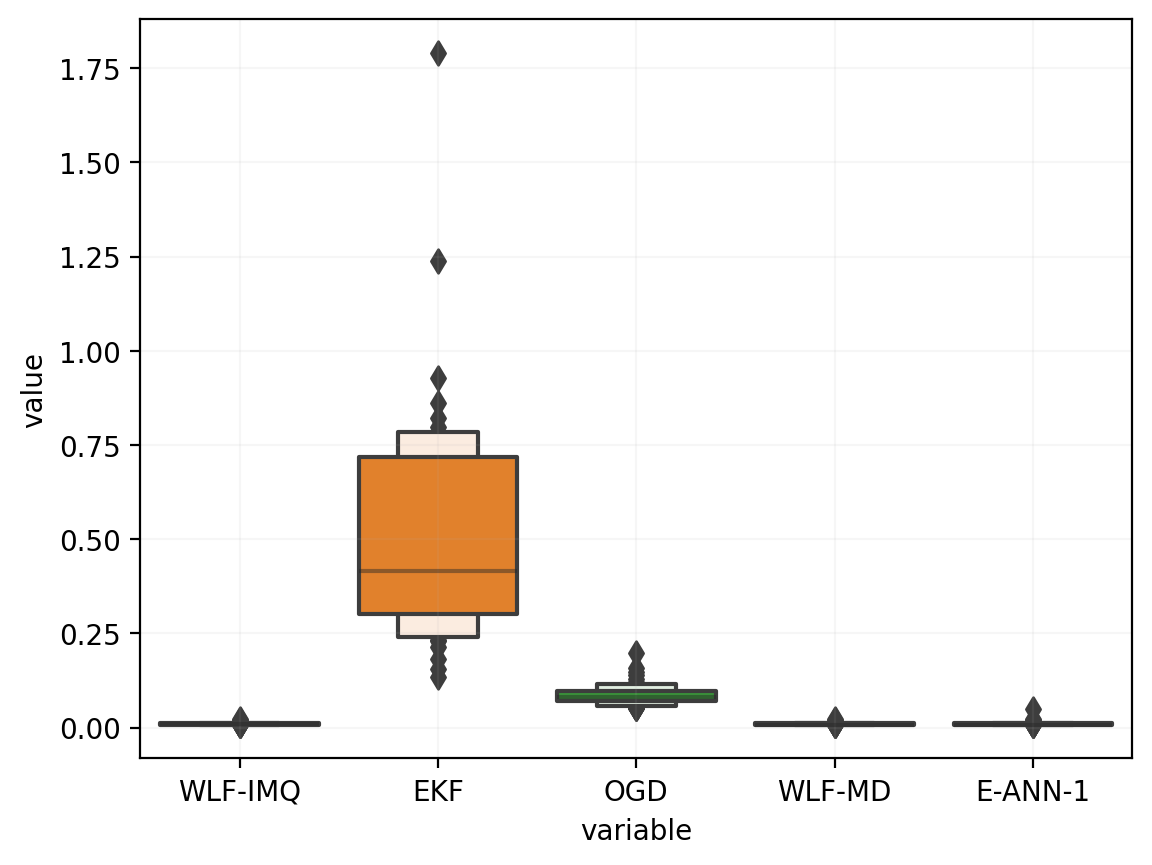

In [524]:
sns.boxenplot(
    x="variable",
    y="value",
    data=df_results.melt().query("value < 30"),
)
plt.grid(alpha=0.1)

In [525]:
err_collection = {
    "methods": {
        "WLF-IMQ": err_collection_wlf,
        "EKF": err_collection_ekf,
        "OGD": err_collection_ogd,
        "WLF-MD": err_collection_mekf,
        "E-ANN-1": err_collection_ann1
    },
    "config": {
        "mask-clean": mask_clean
    }
}

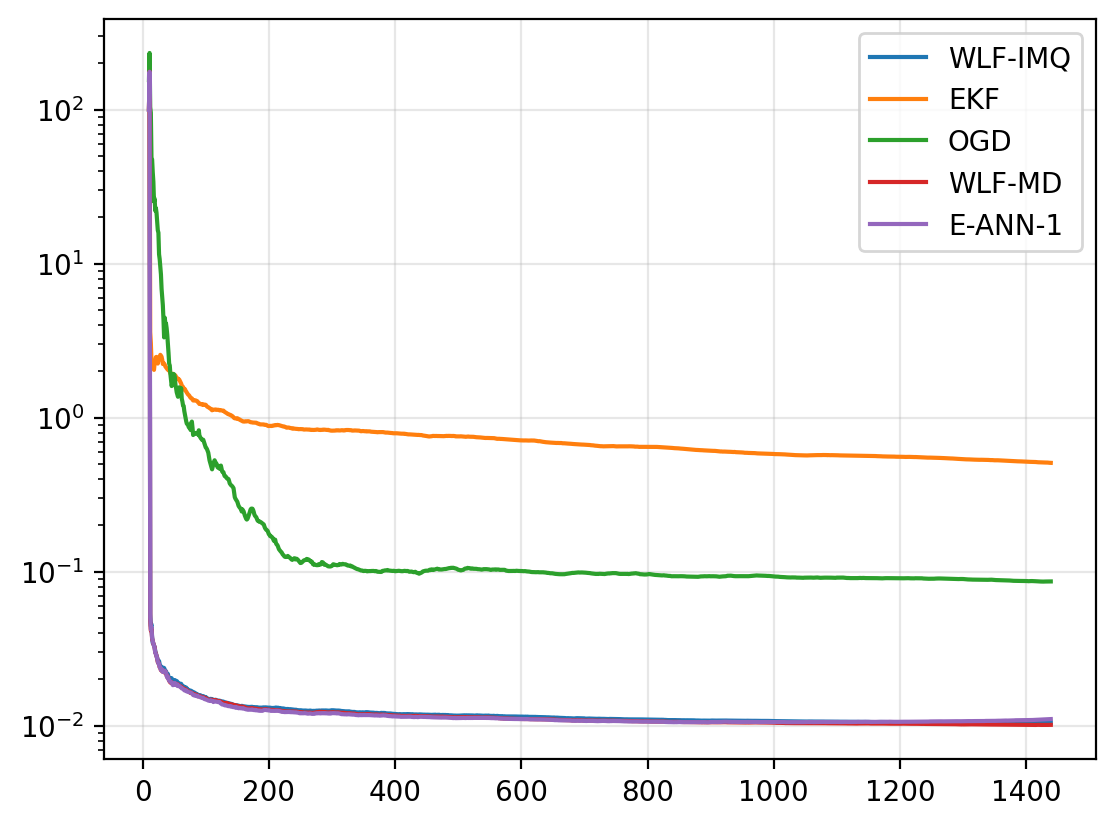

In [526]:
for method in err_collection["methods"]:
    err_collection["methods"][method][10:].expanding().median().mean(axis=1).plot(label=method)
    plt.yscale("log")
    plt.legend()
    plt.grid(alpha=0.3)

In [527]:
with open(f"./results/{dataset_name}-{noise_type}.pkl", "wb") as f:
    pickle.dump(err_collection, f)